In [1]:
import sys
from pathlib import Path
p_root = Path('~/link/csMAHN_Spatial').expanduser()
sys.path.append(str(p_root)) if not str(p_root) in sys.path else None

In [2]:
from init import *
import os

/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-29 22:38:27.297561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------------------------------------------------------
[names import from utils.general]
----------------------------------------------------------
  Block Path json module_exists
  mpl np pd plt
  rng show_dict_key sns subset_dict


In [3]:
item = 'Visium_Fresh_Frozen_Adult_Mouse_Brain'
p_item = Path(item)

for _ in 'analysis,spatial'.split(','):
    if p_item.joinpath('{}_{}.tar.gz'.format(item,_)).exists() and \
    not p_item.joinpath(_).exists():
        os.system('cd {} && tar -zxvf {}_{}.tar.gz && cd ..'\
                  .format(p_item.absolute(),item,_))

In [4]:
row = {}
row['h5_raw'] = p_item.joinpath('{}_raw_feature_bc_matrix.h5'.format(item))
row['h5_filtered'] = p_item.joinpath('{}_filtered_feature_bc_matrix.h5'.format(item))

# UMAP
row['UMAP'] = p_item.joinpath('analysis/umap/gene_expression_2_components',
                                      'projection.csv')
# cluster
row['cluster'] = p_item.joinpath('analysis/clustering/gene_expression_graphclust',
                                'clusters.csv')

# spatial
row['positions'] = p_item.joinpath('spatial','tissue_positions.csv')
row['images_path'] = {
    'lowres':p_item.joinpath('spatial','tissue_lowres_image.png'),
    'hires':p_item.joinpath('spatial','tissue_hires_image.png')
}
row['scalefactors'] = p_item.joinpath('spatial','scalefactors_json.json')

def _func_dict_path_exists(data):
    for k,v in data.items():
        if isinstance(v,dict):
            _func_dict_path_exists(v)
        else:
            print('{}\t{}'.format(v.exists(),k))
_func_dict_path_exists(row)

True	h5_raw
True	h5_filtered
True	UMAP
True	cluster
True	positions
True	lowres
True	hires
True	scalefactors


In [5]:
adata = sc.read_10x_h5(row['h5_filtered'])
adata.var_names_make_unique()
ut.sc.show(adata,show_var=True,show_X_gt_zero=True)

/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2797 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

[check unique]
	obs.index	var.index
	True		True


""
AAACAAGTATCTCCCA-1
AAACAGAGCGACTCCT-1


(2797, 0)

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,mm10
Gm1992,ENSMUSG00000089699,Gene Expression,mm10


(32285, 3)

matrix([[  1.,   1.,   3., ...,  21., 167.,   1.]], dtype=float32)

In [6]:
_temp = pd.read_csv(row['UMAP'],index_col=0)\
.join(pd.read_csv(row['cluster'],index_col=0))\
.join(pd.read_csv(row['positions'],index_col=0))
_temp = _temp.rename(columns={'UMAP-1':'UMAP1','UMAP-2':'UMAP2'})
ut.df.show(_temp)

assert pd.Series(adata.obs.index.isin(_temp.index)).all()
adata.obs = adata.obs.loc[:,[]].join(_temp)

,UMAP1,UMAP2,Cluster,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
Barcode,,,,,,,,
AAACAAGTATCTCCCA-1,6.877725,3.760584,7,1,50,102,7317,9621
AAACAGAGCGACTCCT-1,-5.274061,-6.317486,2,1,14,94,2989,9078


(2797, 8)

In [7]:
ut.sc.load_obsm_UMAP(adata,keys_umap='UMAP1,UMAP2'.split(','))
ut.sc.load_obsm_spatial(adata,keys_pixel='pxl_row_in_fullres,pxl_col_in_fullres'.split(','))

ut.sc.load_uns_spatial(adata,path_imgs=row['images_path'],path_jsons=subset_dict(row,'scalefactors'))

AnnData object with n_obs × n_vars = 2797 × 32285
    obs: 'UMAP1', 'UMAP2', 'Cluster', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'X_umap', 'spatial'

In [8]:
dict_context = {'key_img':'hires','transpose':True}

with Block('',context = dict_context) as context:
    ut.sc.load_spatial_images(adata,key_images=context.key_img,kw_reverse_img={
        'reverse_h':False,'reverse_v':False,'transpose':context.transpose})
    print(*[' '.join(_) for _ in ut.sc.yield_key_uns_spatial_and_key_img(adata)],sep='\n')

spatial hires


In [9]:
adata.obs['Cluster'] = adata.obs['Cluster'].astype(str)
adata.obs.dtypes

UMAP1                 float64
UMAP2                 float64
Cluster                object
in_tissue               int64
array_row               int64
array_col               int64
pxl_row_in_fullres      int64
pxl_col_in_fullres      int64
dtype: object

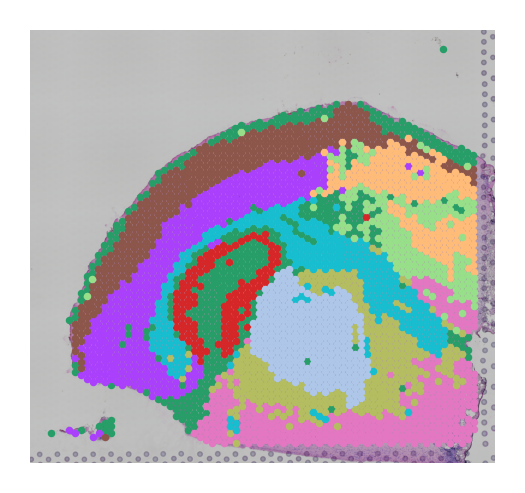

In [10]:
with Block('',context = dict_context) as context:
    fig,ax = pl.figure.subplots_get_fig_axs()
    ut.sc.pl.spatial(adata,key='Cluster',key_img=context.key_img,
                     ax=ax)

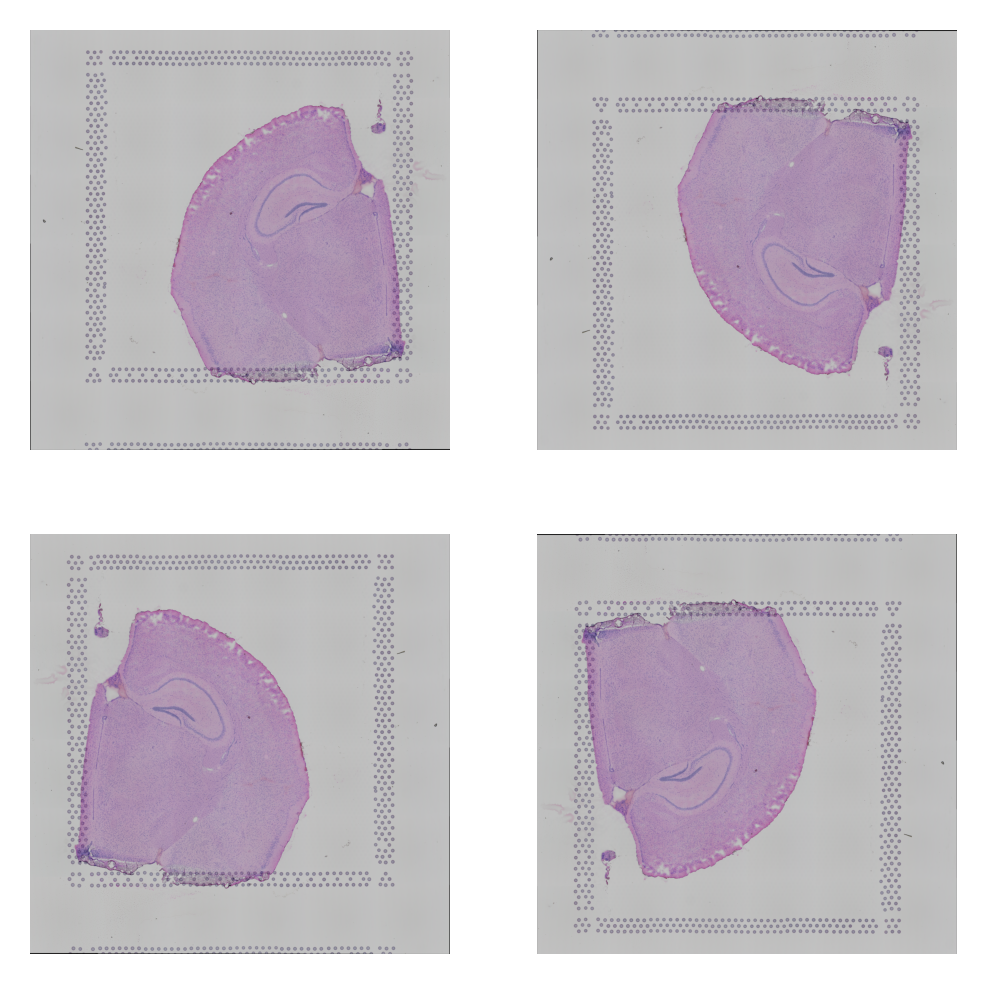

In [12]:
with Block('',context = dict_context) as context:
    fig,axs = pl.figure.subplots_get_fig_axs(2,2)
    
    img_arr = ut.sc.get_img(adata,key_img=context.key_img)
    ax = axs[0]
    ax.imshow(ut.sc.reverse_img(img_arr,reverse_h=False,reverse_v=False,transpose=context.transpose))
    ax.set_axis_off()
    
    ax = axs[1]
    ax.imshow(ut.sc.reverse_img(img_arr,reverse_h=True,reverse_v=False,transpose=context.transpose))
    ax.set_axis_off()
    
    ax = axs[2]
    ax.imshow(ut.sc.reverse_img(img_arr,reverse_h=False,reverse_v=True,transpose=context.transpose))
    ax.set_axis_off()

    ax = axs[3]
    ax.imshow(ut.sc.reverse_img(img_arr,reverse_h=True,reverse_v=True,transpose=context.transpose))
    ax.set_axis_off()